In [107]:
import pandas as pd
import re
import gc
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import wordnet, WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
from tqdm import tqdm_notebook as tqdm
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.preprocessing import LabelEncoder
from bayes_opt import BayesianOptimization
from bayes_opt.observer import JSONLogger
from bayes_opt.event import Events
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

## READ DATASET AND CREATE TEXT AND TARGET

In [2]:
dataset = pd.read_json('data/News_Category_Dataset_v2.json', lines=True)

# keep only text and target category
dataset = dataset.drop(['date', 'link', 'authors'], axis=1)
dataset.head(10)

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,"""It is not right to equate horrific incidents ..."
6,ENTERTAINMENT,Donald Trump Is Lovin' New McDonald's Jingle I...,"It's catchy, all right."
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,There's a great mini-series joining this week.
8,ENTERTAINMENT,Mike Myers Reveals He'd 'Like To' Do A Fourth ...,"Myer's kids may be pushing for a new ""Powers"" ..."
9,ENTERTAINMENT,What To Watch On Hulu That’s New This Week,You're getting a recent Academy Award-winning ...


In [3]:
dataset['category'] = dataset['category'].map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
dataset['category'] = dataset['category'].map(lambda x: "ARTS & CULTURE" if x in ["ARTS", "CULTURE & ARTS"] else x)
dataset['category'] = dataset['category'].map(lambda x: "STYLE & BEAUTY" if x == "STYLE" else x)
dataset['category'] = dataset['category'].map(lambda x: "PARENTING" if x == "PARENTS" else x)
dataset['category'] = dataset['category'].map(lambda x: "FOOD & DRINK" if x == "TASTE" else x)

In [4]:
dataset['category'].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
PARENTING         12632
STYLE & BEAUTY    11903
TRAVEL             9887
FOOD & DRINK       8322
HEALTHY LIVING     6694
QUEER VOICES       6314
WORLDPOST          6243
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
ARTS & CULTURE     3878
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
RELIGION           2556
SCIENCE            2178
WORLD NEWS         2177
TECH               2082
MONEY              1707
FIFTY              1401
GOOD NEWS          1398
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
EDUCATION          1004
Name: category, dtype: int64

In [5]:
dataset = dataset.sample(10000)

In [6]:
dataset['category'].value_counts()

POLITICS          1612
WELLNESS           887
ENTERTAINMENT      790
STYLE & BEAUTY     628
PARENTING          601
TRAVEL             487
FOOD & DRINK       414
HEALTHY LIVING     347
QUEER VOICES       323
BUSINESS           311
WORLDPOST          287
COMEDY             261
SPORTS             260
BLACK VOICES       238
HOME & LIVING      210
DIVORCE            186
WEDDINGS           183
CRIME              175
IMPACT             175
ARTS & CULTURE     174
WOMEN              161
MEDIA              136
WEIRD NEWS         133
GREEN              123
TECH               117
RELIGION           111
WORLD NEWS         108
SCIENCE            106
MONEY               85
GOOD NEWS           79
FIFTY               68
ENVIRONMENT         61
COLLEGE             58
EDUCATION           57
LATINO VOICES       48
Name: category, dtype: int64

In [7]:
le = LabelEncoder()
target = le.fit_transform(dataset['category'].tolist())

In [8]:
dataset['category'].tolist()[:4]

['WELLNESS', 'ENTERTAINMENT', 'BUSINESS', 'HEALTHY LIVING']

In [9]:
target[0:4]

array([31,  8,  2, 14])

In [10]:
texts = (dataset['headline'] + ' ' + dataset['short_description']).tolist()

In [11]:
texts[0:4]

['3 Easy Guided Meditations For Relaxation The stress and strain of constantly being connected can sometimes take your life -- and your well-being -- off course. GPS',
 'Corrupt Politician From \'The Wire\' Says Donald Trump Is Just Like Him "Sheeeeeeeee-it!"',
 "Wells Fargo's New CEO Already Sounding A Little Stressed He hasn't even had the job for a week yet.",
 'Is It Possible To Outrun Your Own Fart? Today in things you never knew you needed to know..']

## TEXT CLEANING

In [12]:
patternAlphaNum = re.compile('[\W_]+')
stops = stopwords.words('english')
wn = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

# helper function to transform pos-tags
# this is ridiculous btw
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def clean_text(text, lemma_or_stem='lemma', word_transformer=wn, pattern=patternAlphaNum, stops=stops):
    # split to words and lowercase
    words = [word.lower() for word in text.split()]
    
    # keep only alphanumeric characters
    words_alphanum = [pattern.sub('', word) for word in words]
    
    # remove stopwords
    words_notstop = [word for word in words_alphanum if not ((word in stops) or (word == ''))]
    
    # lemmatize using pos tags
    if lemma_or_stem == "lemma":
        pos_tags = [get_wordnet_pos(pos[1]) for pos in pos_tag(words_notstop)]
        return ' '.join([word_transformer.lemmatize(word, pos=pos_tag) for word, pos_tag in zip(words_notstop, pos_tags)])
    
    # stemming
    elif lemma_or_stem == "stem":
        return ' '.join([word_transformer.stem(word) for word in words_notstop])
    
    # return raw words
    else:
        return ' '.join(words_notstop)
        

In [13]:
texts_cleaned_lemma = [clean_text(text, 'lemma', wn) for text in tqdm(texts)]
texts_cleaned_stem = [clean_text(text, 'stem', stemmer) for text in tqdm(texts)]

In [14]:
# combine them to 1 text
all_cleaned_text_lemma = '\n'.join(texts_cleaned_lemma)
all_cleaned_text_stem = '\n'.join(texts_cleaned_stem)

# write to file
with open('cleaned_text/cleaned_text_lemma.txt', 'wb') as f:
    f.write(all_cleaned_text_lemma.encode('utf-8'))
with open('cleaned_text/cleaned_text_stem.txt', 'wb') as f:
    f.write(all_cleaned_text_stem.encode('utf-8'))

## FEATURE ENGINEERING

In [15]:
# load text
with open('cleaned_text/cleaned_text_stem.txt', 'rb') as f:
    all_cleaned_text_stem = [line.decode('utf-8').strip('\n') for line in f.readlines()]
with open('cleaned_text/cleaned_text_lemma.txt', 'rb') as f:
    all_cleaned_text_lemma = [line.decode('utf-8').strip('\n') for line in f.readlines()]

In [16]:
# metadata
blobs = [TextBlob(text) for text in texts]
polarities = [blob.polarity for blob in blobs]
subjectivities = [blob.subjectivity for blob in blobs]
lens = [len(text) for text in texts]

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [44]:
tfidf_types = ['unigram_min3','unibigram_min3', 'unibitrigram_min3']

In [45]:
tfidf = {}
tfidf['unigram_min3'] = TfidfVectorizer(min_df=3, max_df=0.5)
tfidf['unibigram_min3'] = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.5)
tfidf['unibitrigram_min3'] = TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.5)

In [46]:
text_vectors = {
    'lemma': {key: value.fit_transform(all_cleaned_text_lemma) for key, value in tfidf.items()},
    'stem': {key: value.fit_transform(all_cleaned_text_stem) for key, value in tfidf.items()}
               }

In [47]:
for key1 in text_vectors.keys():
    for key2 in text_vectors[key1].keys():
        print(f'{key1}_{key2}: {text_vectors[key1][key2].shape}')

lemma_unigram_min3: (10000, 7249)
lemma_unibigram_min3: (10000, 11094)
lemma_unibitrigram_min3: (10000, 11478)
stem_unigram_min3: (10000, 6705)
stem_unibigram_min3: (10000, 10665)
stem_unibitrigram_min3: (10000, 11062)


## FEATURE UNION

In [48]:
def create_dataset(key1, key2, target):
    X = pd.DataFrame(text_vectors[key1][key2].todense())
    X['polarity'] = polarities
    X['subjectivity'] = subjectivities
    X['lens'] = lens
    
    y = copy.copy(target)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test, le

## SIMPLE MODEL TO FIND REPRESENTATION

In [49]:
scores = {}
for i in ['stem', 'lemma']:
    print(i)
    print('-------')
    scores[i] = {}
    for j in tfidf_types:
        print(j)
        tree = DTC(min_samples_split=0.1)
        scores[i][j] = {}
        X_train, X_test, y_train, y_test, le = create_dataset(i, j, target)
        tree.fit(X_train, y_train)
        scores[i][j]['train'] = tree.score(X_train, y_train)
        scores[i][j]['test'] = tree.score(X_test, y_test)
        del X_train, X_test, y_train, y_test, tree
        gc.collect()
        print(scores[i][j])
        print('---')

stem
-------
unigram_min3
{'train': 0.41835820895522385, 'test': 0.3615151515151515}
---
unibigram_min3
{'train': 0.43716417910447763, 'test': 0.36303030303030304}
---
unibitrigram_min3
{'train': 0.4267164179104478, 'test': 0.3612121212121212}
---
lemma
-------
unigram_min3
{'train': 0.41044776119402987, 'test': 0.353030303030303}
---
unibigram_min3
{'train': 0.4, 'test': 0.3496969696969697}
---
unibitrigram_min3
{'train': 0.43029850746268655, 'test': 0.36363636363636365}
---


### let's work with stemmed, uni and bigrams that appear on at least 3 texts and at most 50% of texts!

In [50]:
X_train, X_test, y_train, y_test, le = create_dataset('stem', 'unibigram_min3', target)

In [51]:
# save it to continue work later on
X_train.to_csv('modeling_data/X_train.csv')
X_test.to_csv('modeling_data/X_test.csv')
pd.DataFrame(y_train).to_csv('modeling_data/y_train.csv')
pd.DataFrame(y_test).to_csv('modeling_data/y_test.csv')

## OPTIMIZE MODEL HYPERPARAMETERS

#### LOAD MODEL DATA

In [ ]:
X_train = pd.read_csv('modeling_data/X_train.csv')
X_test = pd.read_csv('modeling_data/X_test.csv')
y_train = pd.read_csv('modeling_data/y_train.csv')
y_test = pd.read_csv('modeling_data/y_test.csv')

#### SET UP OPTIMIZATION

In [52]:
#function to optimize
def rfccv(n_estimators, min_samples_split, max_features):
    val = cross_val_score(
        RFC(n_estimators=int(n_estimators),
            min_samples_split=min_samples_split,
            max_features=min(max_features, 0.999),
            random_state=2
        ),
        X=X_train,
        y=y_train,
        scoring=None,
        cv=3
    ).mean()
    return val

In [54]:
# object which does optimization
params_to_optimize = {'n_estimators': (10, 1000),
                   'min_samples_split': (0.001, 0.2),
                   'max_features': (0.1, 0.999)}

rfcBO = BayesianOptimization(
    rfccv,
    params_to_optimize
)

In [55]:
# log to file rather than prints
logger_rfc = JSONLogger(path="logs/rfc_logs.json")
rfcBO.subscribe(Events.OPTMIZATION_STEP, logger_rfc)

In [56]:
#perform optimization
rfcBO.maximize(init_points=5, n_iter=15)

In [57]:
print('-' * 53)
print('Final Results')
print('RFC: %f' % rfcBO.max['target'])

print('-' * 53)
print('Best Parameters')
print(f'RFC: {rfcBO.max["params"]}')

-----------------------------------------------------
Final Results
RFC: 0.437894
-----------------------------------------------------
Best Parameters
RFC: {'max_features': 0.10217901857765659, 'min_samples_split': 0.022427861157945508, 'n_estimators': 928.7684944755536}


In [58]:
forest = RFC(max_features=rfcBO.max['params']['max_features'], 
             min_samples_split=rfcBO.max['params']['min_samples_split'], 
             n_estimators=int(rfcBO.max['params']['n_estimators']))

In [59]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=0.10217901857765659,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=0.022427861157945508,
                       min_weight_fraction_leaf=0.0, n_estimators=928,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
y_test_pred = forest.predict(X_test)

## EVALUATION

In [63]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix

array([[15,  0,  1, ...,  1,  0,  1],
       [ 0, 11,  1, ...,  0,  0,  0],
       [ 0,  1, 23, ...,  5,  0,  0],
       ...,
       [ 0,  0,  0, ..., 13,  0,  0],
       [ 0,  1,  0, ...,  1,  0,  6],
       [ 0,  1,  1, ...,  0,  2, 13]])

<img src=https://miro.medium.com/max/621/1*uR09zTlPgIj5PvMYJZScVg.png>

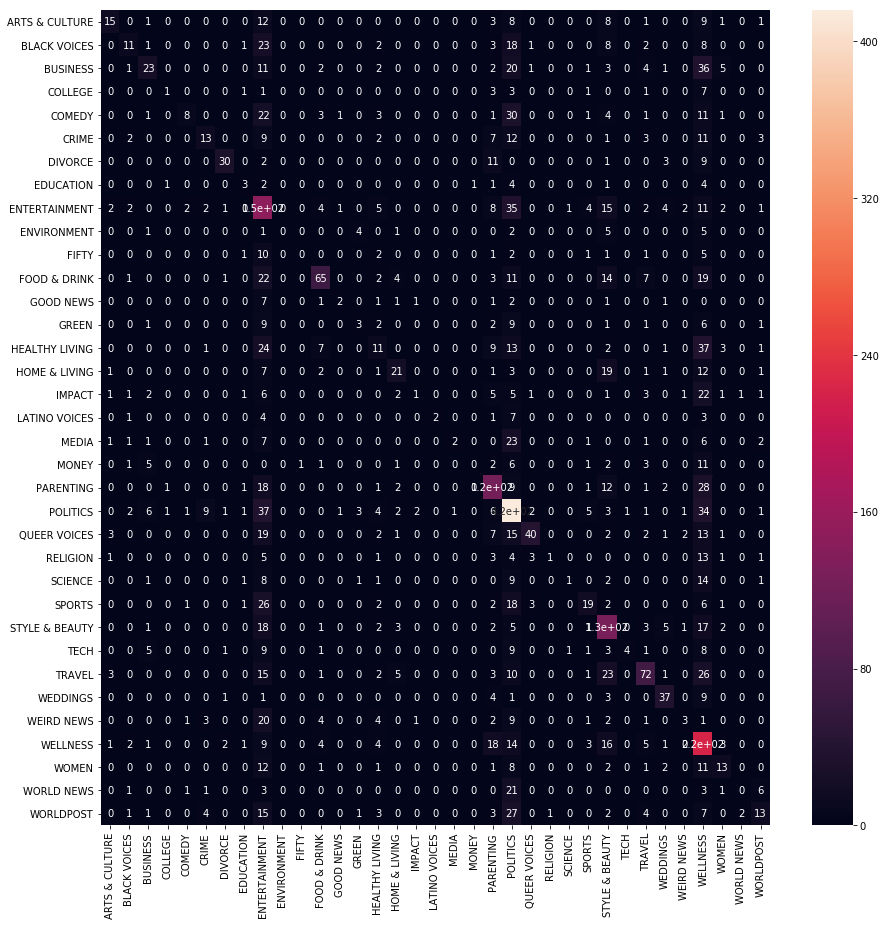

In [78]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_matrix, ax=ax, annot=True,
            xticklabels=le.inverse_transform(list(range(35))),
            yticklabels=le.inverse_transform(list(range(35))))

In [94]:
# calculate metrics by label
recalls = {}
precisions = {}
f1_scores = {}
for label in range(35):
    y_test_label = pd.np.where(y_test==label, 1, 0)
    y_test_pred_label = pd.np.where(y_test_pred==label, 1, 0)
    recalls[label] = recall_score(y_test_label, y_test_pred_label, pos_label=1)
    precisions[label] = precision_score(y_test_label, y_test_pred_label, pos_label=1)
    f1_scores[label] = f1_score(y_test_label, y_test_pred_label, pos_label=1)

/home/kapronczaym/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kapronczaym/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [113]:
# create a df of metrics by label
metrics_df = pd.DataFrame.from_dict(recalls, orient="index", columns=['recall/sens'])
metrics_df['precision/spec'] = metrics_df.index.map(precisions)
metrics_df['f1_score'] = metrics_df.index.map(f1_scores)
metrics_df.index = le.inverse_transform(list(range(35)))

In [117]:
metrics_df

,recall/sens,precision/spec,f1_score
ARTS & CULTURE,0.254237,0.535714,0.344828
BLACK VOICES,0.141026,0.407407,0.209524
BUSINESS,0.205357,0.450980,0.282209
COLLEGE,0.055556,0.250000,0.090909
COMEDY,0.091954,0.571429,0.158416
CRIME,0.206349,0.382353,0.268041
DIVORCE,0.535714,0.810811,0.645161
EDUCATION,0.176471,0.250000,0.206897
ENTERTAINMENT,0.587302,0.273063,0.372796
ENVIRONMENT,0.000000,0.000000,0.000000


In [115]:
metrics_df.sort_values('recall/sens', ascending=False).iloc[:5]

,recall/sens,precision/spec,f1_score
POLITICS,0.768946,0.527919,0.626035
WELLNESS,0.724590,0.343701,0.466245
STYLE & BEAUTY,0.675532,0.444056,0.535865
WEDDINGS,0.660714,0.616667,0.637931
PARENTING,0.620000,0.518828,0.564920


In [116]:
metrics_df.sort_values('precision/spec', ascending=False).iloc[:5]

,recall/sens,precision/spec,f1_score
LATINO VOICES,0.111111,1.000000,0.200000
DIVORCE,0.535714,0.810811,0.645161
TECH,0.093023,0.800000,0.166667
QUEER VOICES,0.370370,0.784314,0.503145
FOOD & DRINK,0.436242,0.670103,0.528455
